# Data Analysis


In [37]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [38]:
# Extend the pandas display windows for easier navigation
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = (
    None  # default='warn', this removes warning on dropping columns
)

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # Warning for future states of used libraries

## Data Import
This notebook uses the output from 02_Create_Target saved at: ../Data/processed/dataset_2016-19_target.

In [39]:
# Read in the dataset prepared in Create_Target notebook
df = pd.read_csv("../Data/processed/dataset_2016-19_target")

/tmp/ipykernel_196915/1533186625.py:2: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/processed/dataset_2016-19_target")


## Data Overview
The first thing we want to do is familiarize ourselves with the data. We start by looking at the first few rows of our table, and then dive into some of the characteristics of the features, like their data type and unique value counts.

In [40]:
df.replace(
    ["democratic republic of the congo"], ["DRC"], inplace=True
)  # This makes many visuals easier to read
df.head()

,numppl,qn1c,qn1d,qn1f,qn1g,qn1h,qn1i,qn1jyear,qn1k,qn2a,qn2b,qn3a,qn4a,qn4b,qn4c,qn4e,qn4j,qn5a,qn5b,qn6a,qn6b,qn7,qn8a,qn9,qn10a,qn11a,qn11aa,qn12,qn13,qn18b,qn18e,qn19b,qn20,qn24a,qn24b,qn25a,qn25b,qn25c,qn25d,qn26b,qn26d,qn26estate,qn26f,qn26h,qn27a,qn27bmnth,qn27byear,qn27c,qn28a,qn28b,qn29b,qn29c,qn29c_months,cohort,ui_agect_arrival,qn30a,qn30d,qn31a,qn31d,qn31e,qn31f,qn32a,qn32d,qn32e,qn33a,qn33d,qn33e,qn33f,qn34a,qn34d,qn34e,qn34f,qn35a,qn38a,qn38b,qn38c,ui_soi_pubassist,ui_soi,Weight_household,Weight_household_pop,qn17_01,qn17_02,qn17_03,qn17_04,qn17_05,qn17_06,qn17_07,qn17_08,qn17_97,qn26ha_01,qn26ha_02,qn26ha_03,qn26ha_04,qn26ha_05,qn26ha_06,qn26ha_07,qn26ha_08,qn26ha_97,qn29a_01,qn29a_02,qn29a_03,qn29a_04,qn29a_05,qn29a_06,qn29a_07,qn29a_08,qn29a_09,qn29a_10,qn29a_11,qn29a_12,qn29a_97,qn29d_01,qn29d_02,qn29d_03,qn29d_04,qn29d_97,ui_qn8a_annual,ui_qn10a_annual,ui_cashassist,ui_lfp,ui_emprate,ui_medicaidrma,ui_lpr,ui_school,ui_work,survey_year,qn17,qn26ha,qn29a,qn29d,t_resettlement
0,4.0,now married,70.0,male,bhutan,bhutan,other,2013.0,northeast,0.0,none,not employed,not at all,not at all,no,no,no,no,no,0.0,0.0,0.00,0.00,0.0,0.0,NaN,0.0,NaN,no,0.000000,never worked in the u.s.,never worked in the u.s.,none/not working,no,0.0,no,not in school,not pursuing degree,not in school,NaN,yes,northeast,NaN,no,no,NaN,NaN,yes,yes,yes,health clinic,NaN,0.0,2013,55 or older,yes,12.0,no,0.0,no,no months,no,0.0,no,no,0.0,no,NaN,no,0.0,no,no months,no,rented for cash rent,950.0,NaN,receives public assistance,"receives public assistance, but earnings missing",1.0943,102.2850,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,age,option not selected,option not selected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,other insurance,option not selected,NaN,NaN,NaN,NaN,NaN,0.00,0.0,does not receive cash assistance,not in labor force,not in labor force,don't know and/or refused,plans to adjust lpr status in future,none,not working now and refused about past,2016,['age'],[],['other insurance'],[],1
1,5.0,now married,32.0,female,somalia,somalia,other,2015.0,midwest,0.0,none,not employed,not at all,not at all,no,no,no,no,no,0.0,0.0,0.00,0.00,0.0,0.0,no,0.0,"no, was not temporarily absent or on layoff",no,0.000000,never worked in the u.s.,never worked in the u.s.,none/not working,no,0.0,no,not in school,not pursuing degree,not in school,17.0,yes,midwest,did not move to another state/it's the first s...,no,no,NaN,NaN,did not know he/she had to apply to become a p...,no,no,health clinic,not covered in any month,0.0,2015,25 to 39 years,yes,12.0,no,0.0,no,no months,no,0.0,no,no,0.0,no,no months,no,0.0,no,no months,no,rented for cash rent,1100.0,yes,receives public assistance,"receives public assistance, but earnings missing",0.5643,52.7460,option not selected,option not selected,option not selected,child care or family responsibilities,option not selected,option not selected,option not selected,option not selected,option not selected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,option not selected,insurance through family member's employment,option not selected,option not selected,NaN,NaN,NaN,NaN,NaN,0.00,0.0,does not receive cash assistance,not in labor force,not in labor force,individual does not receive rma/medicaid,don't know and/or refused,none,not working now and never worked in past,2016,['child care or family responsibilities'],[],"[""insurance through family member's employment""]",[],0
2,1.0,never married,38.0,male,somalia,somalia,other,2012.0,south,5.0,none,not employed,not well,very well,no,no,n

In [41]:
# Display the row counts and data types of each feature
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768 entries, 0 to 5767
Data columns (total 131 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    numppl                5768 non-null   float64
 1    qn1c                  5754 non-null   object 
 2    qn1d                  5666 non-null   float64
 3    qn1f                  5768 non-null   object 
 4    qn1g                  5763 non-null   object 
 5    qn1h                  5603 non-null   object 
 6    qn1i                  5633 non-null   object 
 7    qn1jyear              5768 non-null   float64
 8    qn1k                  5725 non-null   object 
 9    qn2a                  5577 non-null   float64
 10   qn2b                  5714 non-null   object 
 11   qn3a                  5745 non-null   object 
 12   qn4a                  5761 non-null   object 
 13   qn4b                  5754 non-null   object 
 14   qn4c                  5763 non-null   object 
 15   qn

In [42]:
# Get an understanding of the cardinality of each feature
df.nunique()

numppl                     5
qn1c                       7
qn1d                      60
qn1f                       2
qn1g                      17
qn1h                      17
qn1i                      18
qn1jyear                   8
qn1k                       4
qn2a                      21
qn2b                       8
qn3a                       8
qn4a                       4
qn4b                       4
qn4c                       2
qn4e                       2
qn4j                       2
qn5a                       2
qn5b                       2
qn6a                      80
qn6b                      61
qn7                      302
qn8a                     763
qn9                       55
qn10a                    149
qn11a                      2
qn11aa                    61
qn12                       3
qn13                       3
qn18b                     82
qn18e                      4
qn19b                     15
qn20                       8
qn24a                      2
qn24b         

Analyzing numerical and categorical data have different approaches. Before getting in the weeds with either type, we want to split our dataframe up, starting with numerical data.

In [43]:
# Identify columns of interest
num_cols = [
    "t_resettlement",
    "numppl",
    "qn1d",
    "qn2a",
    "qn18b",
    "qn26b",
    "qn29c_months",
    "qn30d",
    "qn31d",
    "qn32d",
    "qn33d",
    "qn34d",
    "qn38b",
    "ui_qn8a_annual",
]

# Rename columns to be easier to read on visuals
num_cols_rename = [
    "t_resettlement",
    "numppl",
    "Age",
    "Pre_Yrs_School",
    "Avg_Hr_Worked",
    "Mth_At_Residence",
    "Refugee_Medical_Mths",
    "FS_Mths",
    "TANF_Mths",
    "RCA_Mths",
    "SSI_Mths",
    "GA_Mths",
    "Housing",
    "Salary_EST",
]

# Filter down to the columns we are interested in, and apply the rename.
num_df = df[num_cols]
num_df.columns = num_cols_rename

# Display statistical features of our numerical columns
num_df.describe()

,t_resettlement,numppl,Age,Pre_Yrs_School,Avg_Hr_Worked,Mth_At_Residence,Refugee_Medical_Mths,FS_Mths,TANF_Mths,RCA_Mths,SSI_Mths,GA_Mths,Housing,Salary_EST
count,5768.000000,5768.000000,5666.000000,5577.000000,5768.000000,5656.000000,5768.000000,5768.000000,5768.000000,5768.000000,5768.000000,5768.000000,5768.000000,5.520000e+03
mean,0.692788,3.328883,39.683022,10.026896,30.871371,23.261669,0.490291,5.660714,0.487344,0.177878,1.989251,0.143637,1087.327925,1.909642e+04
std,0.461378,1.493707,12.554086,4.938139,17.817823,17.113078,1.820326,5.631925,2.241183,1.275171,4.385913,1.256248,696.668263,5.540596e+04
min,0.000000,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,2.000000,30.000000,7.000000,20.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,0.000000e+00
50%,1.000000,4.000000,37.000000,11.000000,40.000000,20.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1.872000e+04
75%,1.000000,5.000000,47.000000,13.000000,40.000000,32.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1300.000000,2.704000e+04
max,1.000000,5.000000,75.000000,20.000000,96.000000,96.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000,20000.000000,3.000000e+06


From personal knowledge of what these features would look like in the real world, these features averages and ranges all look relatively normal. The only exceptions might be the 20,000 monthly housing cost, and the 3M salary. These values are certainly possible, but could be also be a data entry or response mistake. Without being able to confirm or disqualify these numbers, we will want to use them in the model building, but for the sake of visualization, we might want to drop them.

Next let’s take a look at the categorical features. Given that some of these values are taken directly from survey questions, and others are constructed based off those answers, we are going to separate them so that we can discuss them apart from one another.

In [44]:
# Identify our categorical and constructed column names
cat_cols = [
    "qn1c",
    "qn1f",
    "qn1k",
    "qn2b",
    "qn3a",
    "qn4a",
    "qn4b",
    "qn11a",
    "qn13",
    "qn19b",
    "qn20",
    "qn25a",
    "qn26estate",
    "qn26f",
    "qn26h",
    "qn29b",
    "qn38a",
]

const_cols = [
    "ui_soi_pubassist",
    "ui_soi",
    "ui_cashassist",
    "ui_lfp",
    "ui_emprate",
    "ui_medicaidrma",
    "ui_lpr",
    "ui_school",
    "ui_work",
]

# Rename values for columns to be easier to read on visuals
cat_cols_rename = [
    "Marital Status",
    "Gender",
    "Original Region",
    "Pre Degree",
    "Pre Civil Status",
    "Pre Eng Exp",
    "Post Eng Exp",
    "Work Since Resettle",
    "Job Search Past Month",
    "Job Industry",
    "Job Sector",
    "Attended School",
    "Curr State",
    "Relocation Reason",
    "Child Edu Participation",
    "Med Care Source",
    "House Ownership",
]

const_cols_rename = [
    "Public Assist",
    "Source of Income",
    "Cash Assist",
    "Labor Force Participation",
    "Employment",
    "Public Healthcare",
    "Legal Perm. Resident",
    "Educational Pursuit",
    "Work Status",
]

# Apply column filtering and renaming
cat_df = df[cat_cols]
cat_df.columns = cat_cols_rename

const_df = df[const_cols]
const_df.columns = const_cols_rename

## Feature analysis
In this next section we wanted to take a look at a few feature in more detail. We are going to start with a close up on success balance by arrival year, survey year, and overall balance. We also want to showcase what countries and ethnicities are included in this dataset. 

In [45]:
# Overall the survey has decent representation of both success and unsuccessful resettlements
df["t_resettlement"].value_counts()

t_resettlement
1    3996
0    1772
Name: count, dtype: int64

### Arrival and Survey Year Trends
Overall, the purpose of this project is to identify ways to improve refugee resettlement. As such, our key performance indicator is the trend of resettlement success year over year. Considering the context of this dataset, there are two ways to look at this, by year of resettlement, or year of survey. Both of these metrics we would like to see a positive trend with both of these metrics, but if we see a large discrepancy between the two, that would be a very informative find as well.

In [46]:
# Success by arrival year
arr_yr = (
    df.groupby(by="qn1jyear")
    .agg(Count=("t_resettlement", "size"), Success_Rate=("t_resettlement", "mean"))
    .reset_index()
)

# Create base chart with source
base = alt.Chart(arr_yr).encode(
    x=alt.X("qn1jyear:N", title="Arrival Year"),
)

# Add value counts for each year
bar = base.mark_bar().encode(y=alt.Y("Count:Q", title="Count of Respondents"))

# Add resettlement trend line
line = base.mark_line(
    color="green", point={"filled": False, "fill": "white", "color": "green"}
).encode(
    y=alt.Y(
        "Success_Rate:Q", title="Resettlement Success Rate", axis=alt.Axis(format="%")
    )
)

# Combine the plots
(bar + line).resolve_scale(y="independent").properties(
    width=600, title="Count and success rate of resettlement by year"
)

alt.LayerChart(...)

By year of arrival, we see a decently normal distribution with most respondents arriving between 2014 and 2016. Considering this survey is conducted on refugees who have moved here in the past 5 years, and the most recent survey was conducted in 2019, this response distribution makes sense. Looking at resettlement success rates, we also see that it has remained flat throughout the years. Ideally we would like to see this trend have a positive slope, but we can feel reassured that it at least isn't decreasing.

In [47]:
# Success and count by survey year
sur_yr = (
    df.groupby(by="survey_year")
    .agg(Count=("t_resettlement", "size"), Success_Rate=("t_resettlement", "mean"))
    .reset_index()
)

# Create base chart with source
base = alt.Chart(sur_yr).encode(
    x=alt.X("survey_year:N", title="Survey Year"),
)

# Add value counts for each survey year
bar = base.mark_bar().encode(y=alt.Y("Count:Q", title="Count of Respondents"))

# Add resettlement trend line
line = base.mark_line(
    color="green", point={"filled": False, "fill": "white", "color": "green"}
).encode(
    y=alt.Y(
        "Success_Rate:Q", title="Resettlement Success Rate", axis=alt.Axis(format="%")
    )
)

# Combine the plots
(bar + line).resolve_scale(y="independent").properties(
    width=600, title="Count and success rate of resettlement by survey year"
)

alt.LayerChart(...)

As expected, the respondent representation by survey year is flat, and the success rate has remained stable year over year. Having only four years of data limits the findings of any larger trends, but as more years are added this specific metric could be built upon.

### Country and Ethnicity Makeup
An individual’s experience differs drastically from person to person and is impossible to gauge at an individual level. The data gathered during the surveys and the model being built in this project make attempts at using data to approximate these different individuals. A Couple data points included that might act like a good natural grouping of similar people are their country of origin and ethnicity. To get an understanding of the distribution of countries represented in this dataset, we can plot the count of respondents from these countries, and how it has changed over the years.

In [48]:
# Count of country representation (breakdown by year)
ctry_yr = (
    df.groupby(by=["qn1h", "survey_year"])
    .agg(Count=("t_resettlement", "size"))
    .reset_index()
)

# Create horizontal bar graph for each country, broken down by year of survey
alt.Chart(ctry_yr).mark_bar().encode(
    x=alt.X("Count:Q", title="Count of Respondents"),
    y=alt.Y("qn1h:N", title="Country"),
    color="survey_year:N",
).properties(width=700, height=500, title="Respondents by country and survey year")

alt.Chart(...)

There is a wide array of countries represented in our dataset, but the representation for each country is no where near flat, with Iraq having by far the most respondents. By year many of the countries have had consistent representation, but for a few countries like El Salvador and Ukraine, the number of respondents have been increasing in recent years.

In [49]:
# Count of country representation (breakdown by year)
eth_yr = (
    df.groupby(by=["qn1i", "survey_year"])
    .agg(Count=("t_resettlement", "size"))
    .reset_index()
)

# Create horizontal bar graph for each ethnicity, broken down by year of survey
alt.Chart(eth_yr).mark_bar().encode(
    x=alt.X("Count:Q", title="Count of Respondents"),
    y=alt.Y("qn1i:N", title="Ethnicity"),
    color="survey_year:N",
).properties(width=700, height=500, title="Respondents by ethnicity and survey year")

alt.Chart(...)

Seeing a few ethnicities with only very monolithic survey years, we were curious if they were just missed in previous surveys, or if there has been an influx from those countries recently. To check this, we filter our data frame down to just the ethnicities of interest, and recreate the chart with year of arrival.


In [50]:
# Filter dataframe to only include ethnicities reporting in 1 survey year
mono_df = df[
    df["qn1i"].isin(
        ["fars", "kurd", "rohingya", "siryac", "tigrinya", "tutsi", "ukrainian"]
    )
]

# Create horizontal bar graph for each ethnicity, broken down by year of arrival
alt.Chart(mono_df).mark_bar().encode(
    x=alt.X("count(*):Q", title="Count of Respondents"),
    y=alt.Y("qn1i:N", title="Ethnicity"),
    color="qn1jyear:N",
).properties(width=700, height=500, title="Respondents by ethnicity and arrival year")

alt.Chart(...)

It does appear that there was decent representation of many of these ethnicities within the US prior to the survey year that they started showing up. For many of these ethnicities there was an influx in the year or two immediately prior to the survey year they started seeing representation. Examples of this could be the Fars people seeing about half their respondents having arrived in 2016, while they saw all of their representation appear in 2017's survey. Similar cases can be found with the Ukrainian and Tigrinya populations.

### Column Type overview
In this next section we take a very high level view at all of the numerical features. This section is more exploratory, and we just want to see if there are any trends worth digging more into.

#### Numrical columns visualization

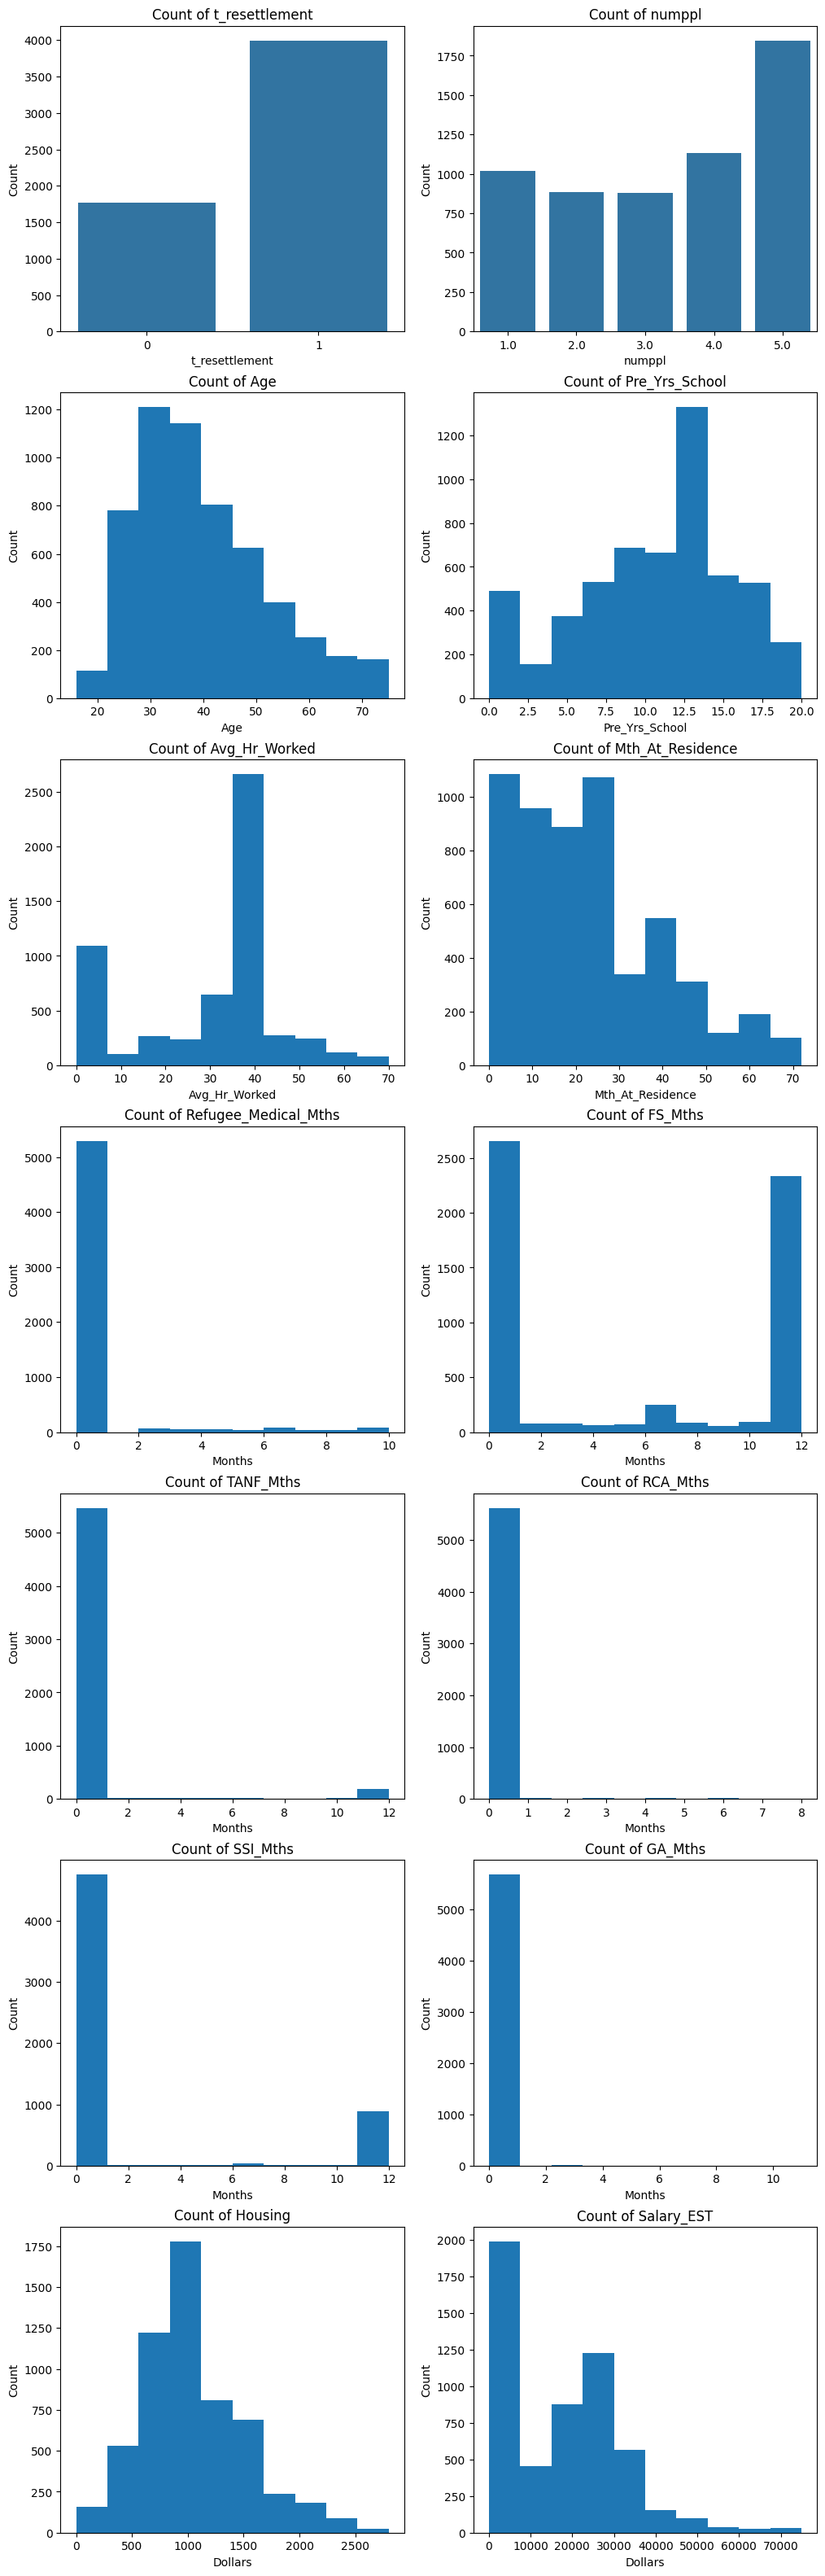

In [51]:
fig, axes = plt.subplots(7, 2, figsize=(12, 40))

sns.countplot(ax=axes[0, 0], x=num_df["t_resettlement"], color="#1f77b4")
sns.countplot(ax=axes[0, 1], x=num_df["numppl"], color="#1f77b4")

axs = axes.ravel()
i = 0
for axes in axs.flat:
    axes.set(ylabel="Count")

for col in num_cols_rename:
    x = num_df[col]
    filtered = x[x.between(0, x.quantile(0.99))].astype(
        int
    )  # Removing outliers for graph readability
    if col in ["t_resettlement", "numppl"]:
        axs[i].set_title("Count of " + col)
        i += 1
        continue
    else:
        axs[i].hist(filtered)
        axs[i].set_title("Count of " + col)

        if "Mths" in col:
            axs[i].set(xlabel="Months")
        elif col in ["Housing", "Salary_EST"]:
            axs[i].set(xlabel="Dollars")
        else:
            axs[i].set(xlabel=col)

        i += 1

Nothing in these charts really jumps out as anything worth digging into, with most being clustered around what we might consider a normal value, such as housing at 1,000, salary at 28,000, or years of school around 12. Looking at the spreads of how many months a respondent has used one form of government assistance or another, there is only significant numbers at either end of the 0-12 month range.

#### Categorical Columns Visualization

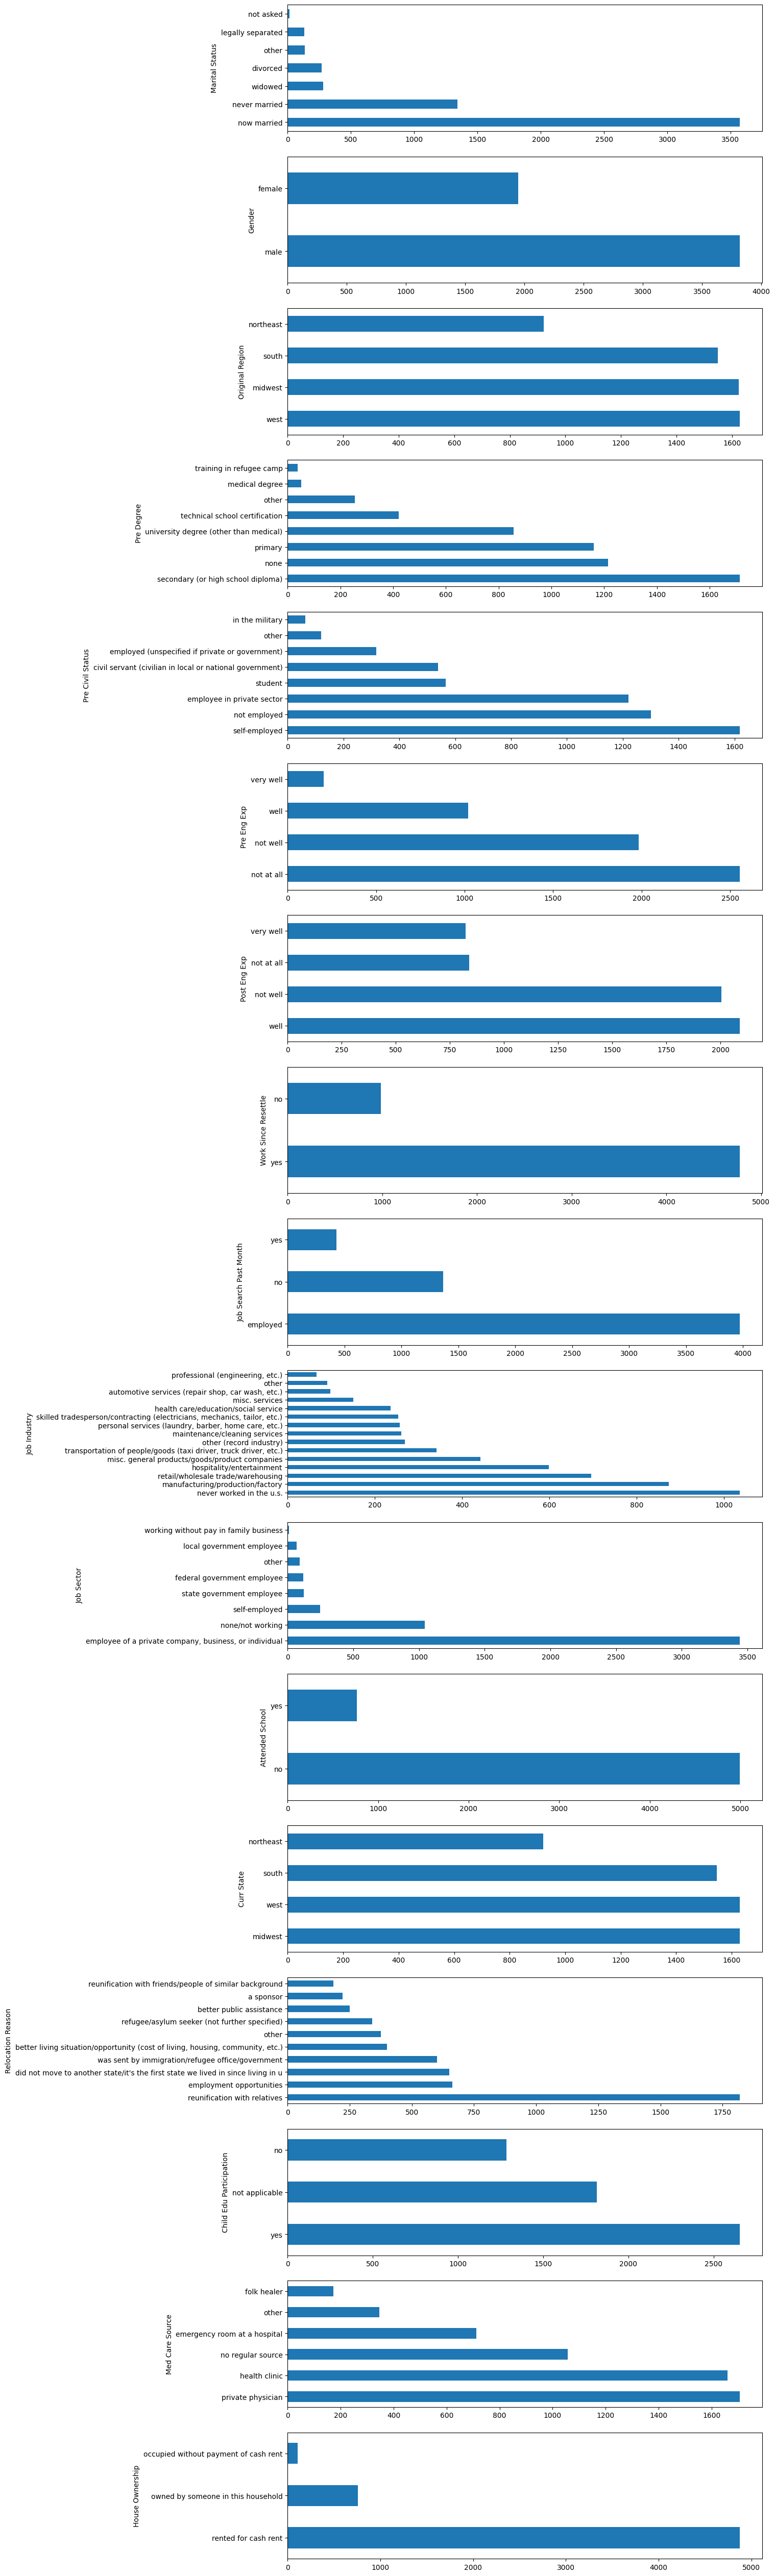

In [52]:
fig, axes = plt.subplots(17, 1, figsize=(12, 65))

cat_df["House Ownership"].replace(
    "owned by you or someone in this household with or without a mortgage or loan",
    "owned by someone in this household",
    inplace=True,
)
i = 0
for col in cat_cols_rename:
    cat_df[col].value_counts().plot.barh(ax=axes[i])
    i += 1

For categorical features, a few callouts come to mind. The gender representation in the dataset skews rather heavily toward males, and if it turns out that this feature has an impact on the outcome of our models, it might be worth looking more into. While the dataset unfortunately doesn't go as granular as the state where the respondent resides, it does have the region, and there is a pretty even distribution between the regions, aside from the northeast which has considerably less representation.

One interesting piece of information this survey collects is how well the respondent spoke English prior to entering the United States, and at the time of survey. Understanding if there is a correlation between an individual improving in this metric, and their success status is certainly worth looking into.

Finally, there is a drastic difference in the number of respondents renting versus owning their home, with nearly 6x as many renting. This is the opposite of the national numbers where only 36% of individuals rent their home (https://www.pewresearch.org/short-reads/2021/08/02/as-national-eviction-ban-expires-a-look-at-who-rents-and-who-owns-in-the-u-s/). This is another feature whose impact might be worth looking at.


#### Constructed Columns Visualization

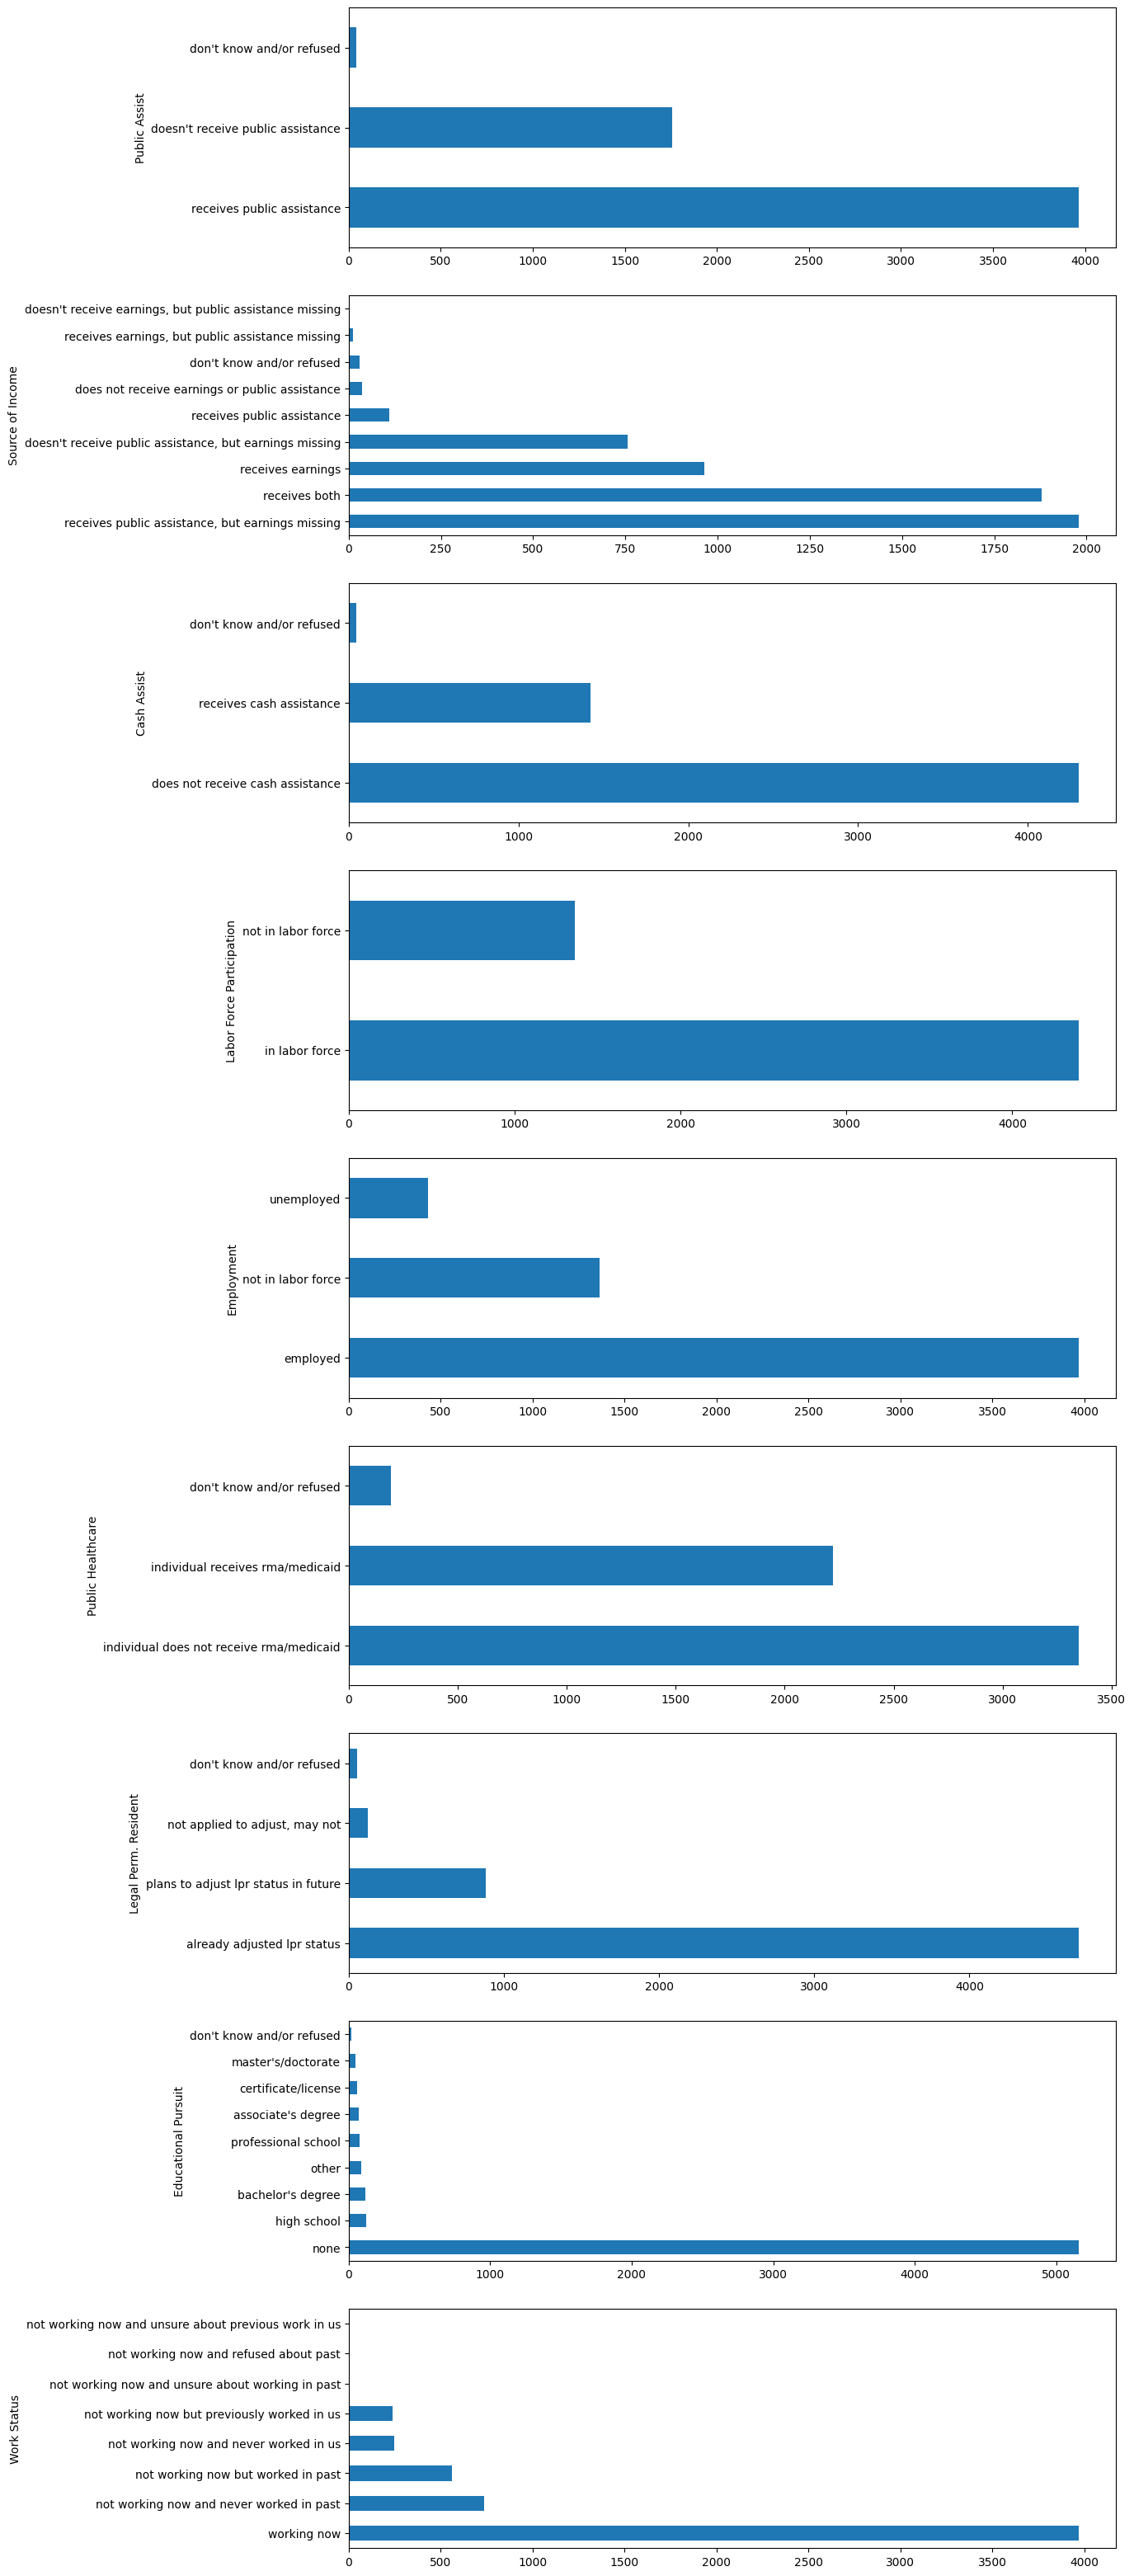

In [53]:
fig, axes = plt.subplots(9, 1, figsize=(12, 40))

i = 0
for col in const_cols_rename:
    const_df[col].value_counts().plot.barh(ax=axes[i])
    i += 1

Constructed variables come from combinations of questions that were asked during the survey. For example, here is the definition of the Employment (ui_emprate) feature from the user guide:

*ui_emprate: This variable reports individuals’ employment status: employed, unemployed, not in the labor force, or doesn’t know or refused to respond. It was created using responses to qn5a and qn13. Individuals are considered “employed” if they report working at a job anytime the week before survey administration (qn5a), “unemployed” if they report not working at a job anytime the week before survey administration (qn5a) and looking for work during the four weeks before survey administration (qn13), and “not in the labor force” if they report not working at a job anytime the week before survey administration (qn5a) and either report not looking for work during the four weeks before survey administration, don’t know, or refuse to respond (qn13). Respondents who either don’t know or refuse to respond to qn5a are marked “Don’t know and/or refused” for ui_emprate.*

We aren't going to go too deep into analysis of these features as we view them more as the outcome of the survey, and what we based our success metric on, but there are a few quick takeaways worth mentioning. As reported, most of the respondents are active in the work force and are currently working. Given their role in the work force, it isn't a surprise to see that very few are in school. Lastly, while most respondents receive public assistance, this assistance isn’t in the form of cash assistance, which includes Temporary Assistance for Need Families (TANF), Refugee Cash Assistance (RCA), Supplemental Security Income (SSI), and General Assistance (GA).


With ourselves familiarized with the dataset, and some specific insights called out, we can move on to machine learning portion of this project where we aim to understand how we can use this data to improve the resettlement success rate.